## Smoothly varying noise process

This notebook demonstrates a nonstationary noise process which varies smoothly over time. It uses a nonstationary covariance kernel, whose time-varying parameters are modelled using Gaussian processes.

First, we use Pints to generate a logistic growth model, with noise increasing in magnitude as the function value increases.

In [1]:
import flexnoise
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy

np.random.seed(222)

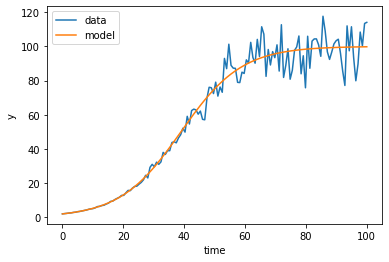

In [2]:
times = np.linspace(0, 100, 140)
model = pints.toy.LogisticModel()
real_parameters = [0.1, 100]

values = model.simulate(real_parameters, times)

data = values + pints.noise.multiplicative_gaussian(1.5, 0.01, values)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(times, data, label='data')
ax.plot(times, values, label='model')
ax.set_xlabel('time')
ax.set_ylabel('y')
ax.legend()

The next step is to combine the model and data into a Pints problem, and select the nonstationary Laplacian kernel.

In [3]:
problem = pints.SingleOutputProblem(model, times, data)
kernel = flexnoise.kernels.GPLaplacianKernel

Once a Pints problem has been constructed, the noise process can be instantiated. In addition to the problem and kernel, it requires us to specify an initial condition for the model parameters, and a set of time points on which to infer the Gaussian process values. This set of time points does not have to coincide with the time points of the data. 

In [4]:
gp_times = np.linspace(0, 100, 20)
gnp = flexnoise.GPNoiseProcess(
        problem,
        kernel,
        [0.1, 100],
        gp_times)

gnp.set_gp_hyperparameters(mu=0.0, alpha=1.0, beta_num_points=150)

Next, a MAP estimate of the noise can be fit.

In [5]:
result = gnp.run_optimize(num_restarts=25, iprint=True, parallel=False)

Finally, we can use `flexnoise.plot` to produce a visualization of the nonstationary noise fit. For this figure, we add a dashed line showing the true value of the standard deviation, which is taken from the multiplicative noise generator used above

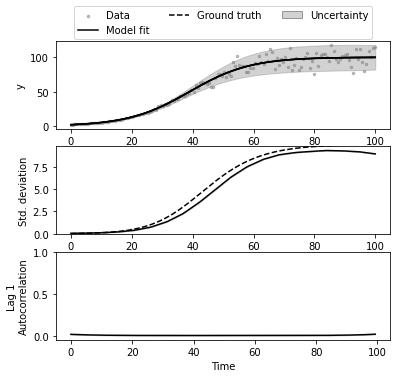

In [6]:
def true_std(t):
    return 0.01 * values ** 1.5

fig = flexnoise.plot.plot_nonstat_fit(
    problem,
    kernel=kernel(None, gp_times),
    samples=result,
    true_std=true_std,
    fname=None)

plt.show()